In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt

%matplotlib inline

USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'
print_every = 100
print('Using device: ', device)

Using device:  /device:GPU:0


In [ ]:
def load_cifar10(num_training=49000, num_validation=1000, num_test=10000):
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

    return X_train, y_train, X_val, y_val, X_test, y_test

NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,) int32
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


[6 9 9 4 1 1 2 7 8 3]
2.0946307 -1.9888586


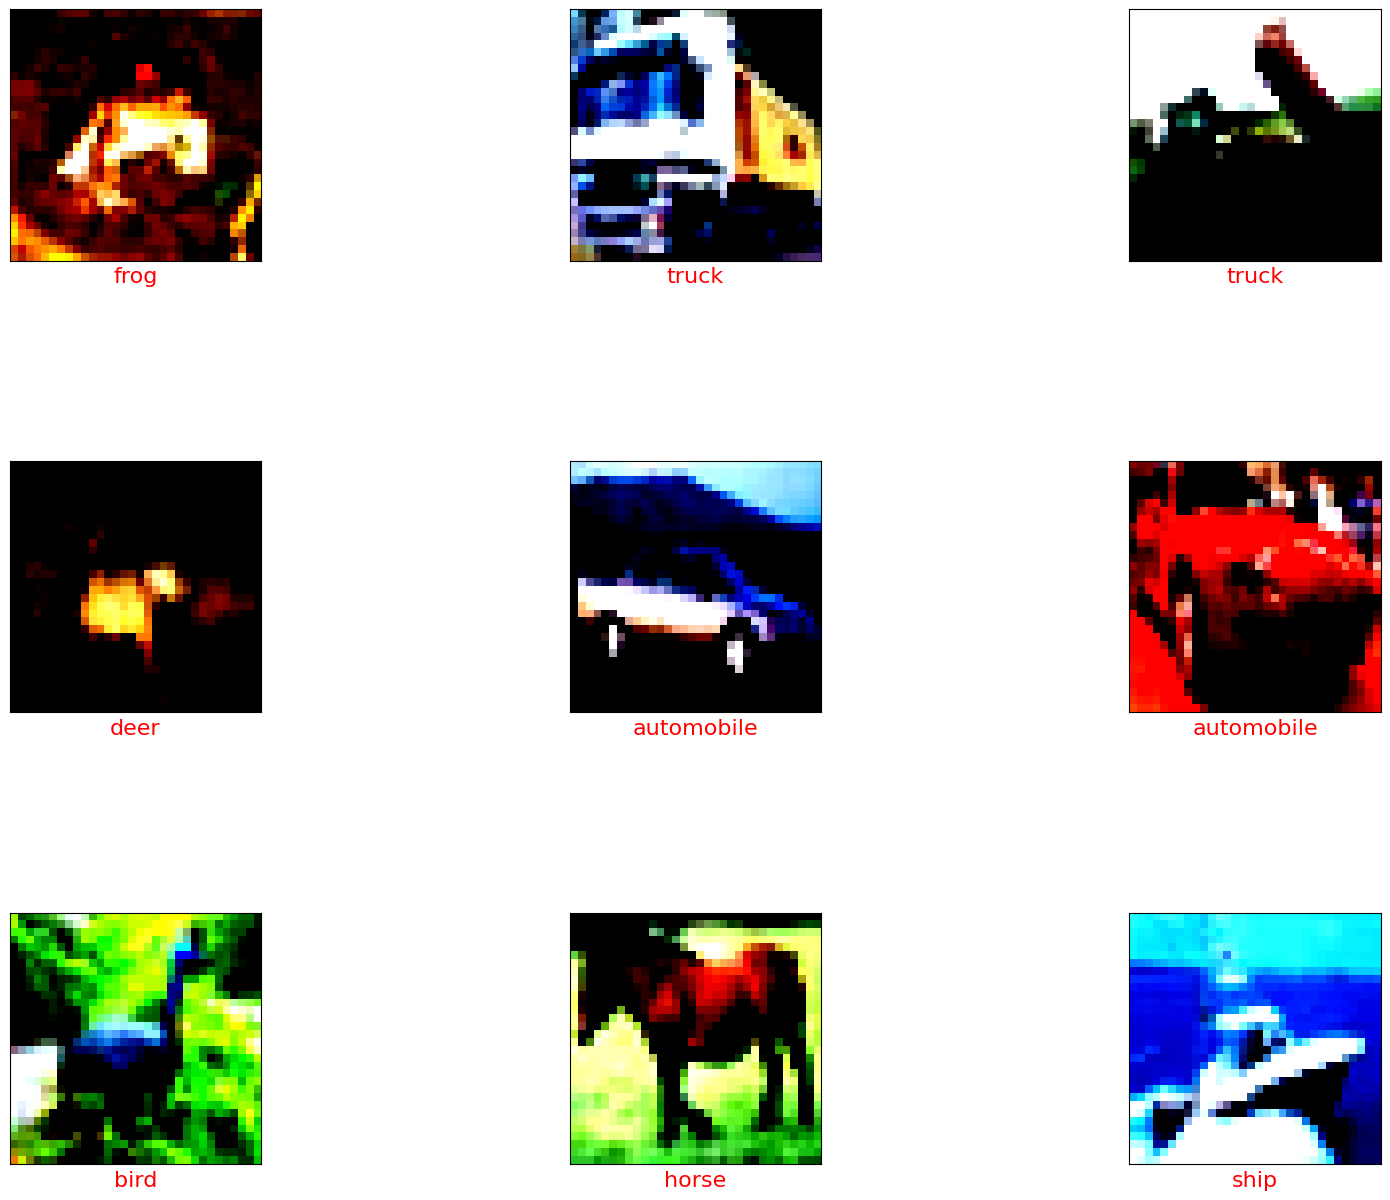

In [ ]:
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore', category=Warning, module='matplotlib')
labelNames=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def plot_cifar_images(images,class_label):
    fig,axes=plt.subplots(3,3,figsize=(20, 15))
    fig.subplots_adjust(hspace=0.8,wspace=0.3)

    for i,ax in enumerate(axes.flat):
        ax.imshow(X_train[i])
        xlab=labelNames[int(class_label[i])]
        ax.set_xlabel(xlab,fontsize=16)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.xaxis.label.set_color('red')
images=X_train[0:100]
cls=y_train[0:100]

print(y_train[0:10])
print(np.max(X_train[0]), np.min(X_train[0]))
plot_cifar_images(images,cls)

In [ ]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        assert X.shape[0] == y.shape[0]
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=64)

In [ ]:
for t, (x, y) in enumerate(train_dset):
    print(t, x.shape, y.shape)
    if t > 5: break

0 (64, 32, 32, 3) (64,)
1 (64, 32, 32, 3) (64,)
2 (64, 32, 32, 3) (64,)
3 (64, 32, 32, 3) (64,)
4 (64, 32, 32, 3) (64,)
5 (64, 32, 32, 3) (64,)
6 (64, 32, 32, 3) (64,)


In [ ]:
def train_part34(model_init_fn, optimizer_init_fn, num_epochs=1, is_training=False):
  with tf.device(device):
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

        model = model_init_fn()
        optimizer = optimizer_init_fn()

        train_loss = tf.keras.metrics.Mean(name='train_loss')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        val_loss = tf.keras.metrics.Mean(name='val_loss')
        val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

        t = 0
        for epoch in range(num_epochs):

            train_loss.reset_states()
            train_accuracy.reset_states()

            for x_np, y_np in train_dset:
                with tf.GradientTape() as tape:

                    scores = model(x_np, training=is_training)
                    loss = loss_fn(y_np, scores)

                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                    train_loss.update_state(loss)
                    train_accuracy.update_state(y_np, scores)

                    if t % print_every == 0:
                        val_loss.reset_states()
                        val_accuracy.reset_states()
                        for test_x, test_y in val_dset:
                            prediction = model(test_x, training=False)
                            t_loss = loss_fn(test_y, prediction)

                            val_loss.update_state(t_loss)
                            val_accuracy.update_state(test_y, prediction)

                        template = 'Iteration {}, Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
                        print (template.format(t, epoch+1,
                                             train_loss.result(),
                                             train_accuracy.result()*100,
                                             val_loss.result(),
                                             val_accuracy.result()*100))
                    t += 1

In [ ]:
class CustomConvNet(tf.keras.Model):
    def __init__(self):
        super(CustomConvNet, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size = 3, padding='same', activation='relu', input_shape=(32, 32, 3))
        self.BN1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(32, kernel_size= 3, padding='same', activation='relu')
        self.pool1 = tf.keras.layers.MaxPooling2D()
        self.BN2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu', padding='same')
        self.conv4 = tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu', padding='same')
        self.pool2 = tf.keras.layers.MaxPooling2D()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.dense2 = tf.keras.layers.Dense(10, activation='softmax')
        pass
    def call(self, input_tensor, training=True):
        x = self.conv1(input_tensor)
        x = self.BN1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.BN2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x, training=training)
        x = self.dense2(x)
        pass

        return x

print_every = 700
num_epochs = 2

model = CustomConvNet()

def model_init_fn():
    return CustomConvNet()

def optimizer_init_fn():
    learning_rate = 1e-3
    return tf.keras.optimizers.Adam(learning_rate)

train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epochs, is_training=True)

Iteration 0, Epoch 1, Loss: 2.693438768386841, Accuracy: 12.5, Val Loss: 2.504822015762329, Val Accuracy: 7.90000057220459
Iteration 700, Epoch 1, Loss: 1.5234096050262451, Accuracy: 44.924659729003906, Val Loss: 1.097344160079956, Val Accuracy: 60.900001525878906
Iteration 1400, Epoch 2, Loss: 1.0406814813613892, Accuracy: 63.04625701904297, Val Loss: 0.8887898921966553, Val Accuracy: 69.5999984741211
Iteration 2100, Epoch 3, Loss: 0.8415929675102234, Accuracy: 70.1449966430664, Val Loss: 0.7886279225349426, Val Accuracy: 73.19999694824219
Iteration 2800, Epoch 4, Loss: 0.7064262628555298, Accuracy: 75.35102081298828, Val Loss: 0.7451468706130981, Val Accuracy: 74.9000015258789
Iteration 3500, Epoch 5, Loss: 0.6020943522453308, Accuracy: 78.86870574951172, Val Loss: 0.7875849008560181, Val Accuracy: 75.0
Iteration 4200, Epoch 6, Loss: 0.5232052206993103, Accuracy: 81.68800354003906, Val Loss: 0.7389068603515625, Val Accuracy: 77.30000305175781
Iteration 4900, Epoch 7, Loss: 0.44339945

In [ ]:
from tensorflow.keras.optimizers import SGD

def lr_schedule(epoch):
    lr = 0.01
    if epoch > 50:
        lr *= 0.1
    elif epoch > 75:
        lr *= 0.01
    return lr

sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

from tensorflow.keras.callbacks import LearningRateScheduler

lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min')

history= model.fit(X_train, y_train, epochs=5, verbose=1, callbacks=[early_stopping_cb],
          validation_data=(X_val, y_val))

Epoch 1/5
1532/1532 [==============================] - 11s 6ms/step - loss: 1.3747 - accuracy: 0.5013 - val_loss: 1.0077 - val_accuracy: 0.6360
Epoch 2/5
1532/1532 [==============================] - 9s 6ms/step - loss: 0.9654 - accuracy: 0.6594 - val_loss: 0.8168 - val_accuracy: 0.7190
Epoch 3/5
1532/1532 [==============================] - 8s 5ms/step - loss: 0.8057 - accuracy: 0.7168 - val_loss: 0.7733 - val_accuracy: 0.7470
Epoch 4/5
1532/1532 [==============================] - 9s 6ms/step - loss: 0.6955 - accuracy: 0.7573 - val_loss: 0.7237 - val_accuracy: 0.7530
Epoch 5/5
1532/1532 [==============================] - 9s 6ms/step - loss: 0.6003 - accuracy: 0.7879 - val_loss: 0.7838 - val_accuracy: 0.7270


Text(0.5, 1.0, 'Train - Accuracy')

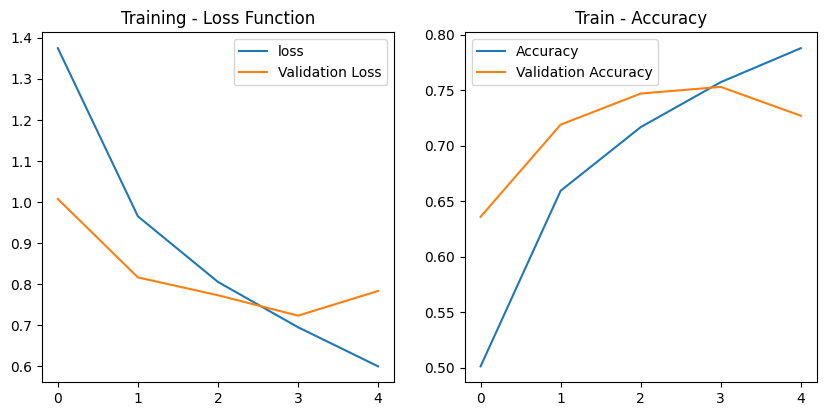

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [ ]:
model_evaluation_results = model.evaluate(X_test, y_test, batch_size=32, verbose=2)
print("The test loss is", model_evaluation_results[0])
print("The test accuracy is", model_evaluation_results[1])

313/313 - 1s - loss: 0.7800 - accuracy: 0.7343 - 975ms/epoch - 3ms/step
The test loss is 0.7799919843673706
The test accuracy is 0.7343000173568726


In [ ]:
practical_test_images =  X_test[:10]
prediction_probabilites = model.predict(practical_test_images)
prediction_probabilites[:3]

1/1 [==============================] - 0s 242ms/step


array([[9.2089707e-03, 5.6299209e-03, 1.0141201e-02, 7.5059247e-01,
        5.0675115e-03, 2.8680583e-02, 1.1197919e-01, 1.0904825e-03,
        6.8614192e-02, 8.9954259e-03],
       [6.9058629e-08, 5.3401669e-05, 1.1090569e-11, 1.2076023e-11,
        1.1371051e-13, 6.9998739e-15, 8.1318806e-12, 7.2460552e-15,
        9.9994648e-01, 5.9496927e-09],
       [5.9154410e-02, 7.5858909e-01, 1.5263283e-03, 4.3414830e-04,
        3.9778888e-04, 4.5712026e-05, 1.4411673e-04, 2.6182565e-04,
        1.3851216e-01, 4.0934402e-02]], dtype=float32)

In [ ]:
def derive_predicted_classes(prediction_probabilites):
    batch_prediction = []
    for vector in prediction_probabilites:
        batch_prediction.append(np.argmax(vector))
    return batch_prediction

model_prediction = derive_predicted_classes(prediction_probabilites)
model_prediction

[3, 8, 1, 0, 6, 6, 1, 6, 3, 1]

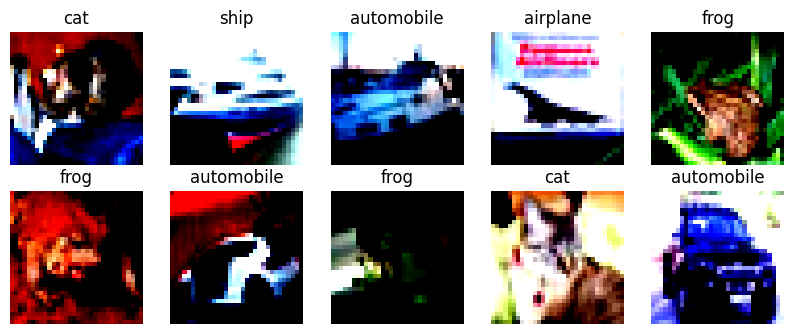

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(practical_test_images)):
    plt.subplot(5,5, i+1)
    plt.axis("off")
    plt.grid(False)
    plt.imshow(practical_test_images[i])
    plt.title(labelNames[model_prediction[i]])
plt.show()

In [ ]:
image_rows = 28
image_cols = 28
batch_size = 4096
image_shape = (image_rows,image_cols,1)
model.summary()

Model: "custom_conv_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  896       
                                                                 
 batch_normalization (Batch  multiple                  128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           multiple                  9248      
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  multiple                  128       
 chNormalization)                                                
                                                   

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Calculate accuracy score
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", accuracy)

313/313 [==============================] - 1s 2ms/step
Accuracy: 0.7343


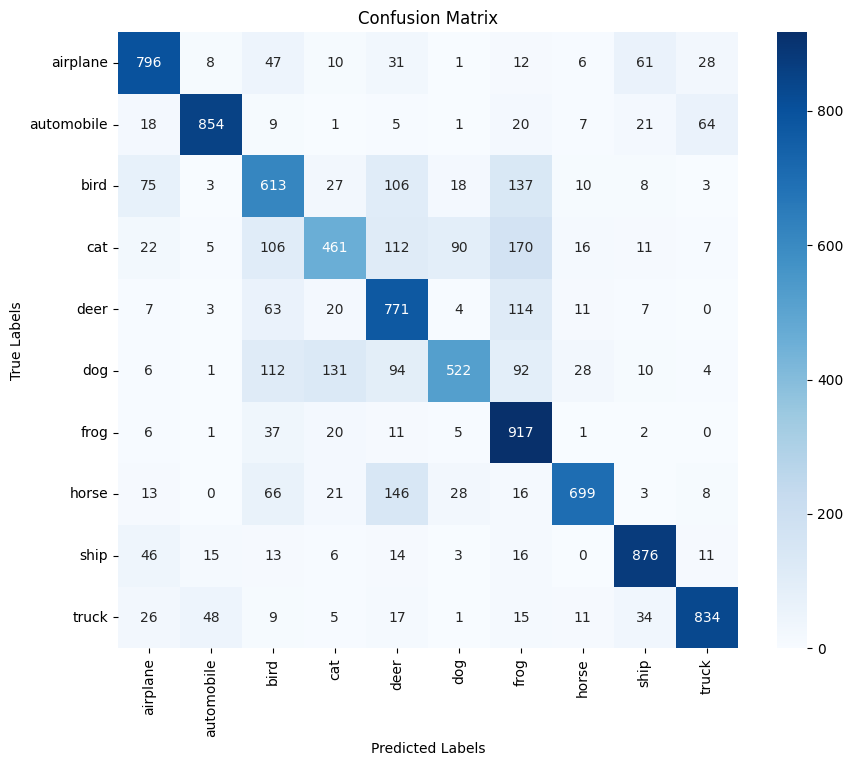

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes)

# Display confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labelNames, yticklabels=labelNames)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
classification_rep = classification_report(y_test, y_pred_classes, target_names=labelNames)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

    airplane       0.78      0.80      0.79      1000
  automobile       0.91      0.85      0.88      1000
        bird       0.57      0.61      0.59      1000
         cat       0.66      0.46      0.54      1000
        deer       0.59      0.77      0.67      1000
         dog       0.78      0.52      0.62      1000
        frog       0.61      0.92      0.73      1000
       horse       0.89      0.70      0.78      1000
        ship       0.85      0.88      0.86      1000
       truck       0.87      0.83      0.85      1000

    accuracy                           0.73     10000
   macro avg       0.75      0.73      0.73     10000
weighted avg       0.75      0.73      0.73     10000

